# Visualizing UCI Drug Consumption Data

[This](https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29) is the data set that I will be trying to understand.  Unforunately I don't think the sample size is big enough for effective training of a classifier, but I could easily be wrong and I'm going to try anyway.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import constants

from pylab import *
from functools import reduce

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [2]:
FILE_NAME = "drug_consumption_data.txt"
NUM_FEATURES = 12

In [3]:
with open(FILE_NAME) as f:
    lines = f.readlines()

features = []
usages = []
cases = []
for line in lines:
    # First elem in line is an id number
    line = line.strip('\n').split(',')[1:]
    feature = line[:NUM_FEATURES]
    usage = line[NUM_FEATURES:]
    features.append(feature)
    usages.append(usage)
    cases.append((feature,usage))
    
def classify_usage(usage_code):
    if usage_code in constants.USER:
        return 1
    else:
        return 0

def process_case(case):
    x, y = case
    return (list(map(float, x)), list(map(classify_usage, y)))
cases = list(map(process_case, cases))

So now we have `cases` set up, holding a list of pairs of the form (features, usages).  The features are the raw, real values given by the dataset while the usages are a `1` or `0` corresponding to whether the individual is considered a user of each drug.

In [4]:
# Mappings given by dataset
age_val_to_label = {
    -0.95197: "18-24",
    -0.07854: "25-34",
    0.49788: "35-44",
    1.09449: "45-54",
    1.82213: "55-64",
    2.59171: "65+"
}

gender_val_to_label = {
    -0.48246: "Male",
    0.48246: "Female"
}

edu_val_to_label = {
    -2.43591: "< 16",
    -1.73790: "16",
    -1.43719: "17",
    -1.22751: "18",
    -0.61113: "College",
    -0.05921: "Cert",
    0.45468: "Degree",
    1.16365: "Masters",
    1.98437: "PhD"
}

country_val_to_label = {
    -0.09765: "Australia",
    0.24923: "Canada",
    -0.46841: "New Zealand",
    -0.28519: "Other",
    0.21128: "Ireland",
    0.96082: "UK",
    -0.57009: "USA"
}

In [5]:
val_to_label = {
    "age": age_val_to_label,
    "gender": gender_val_to_label,
    "education": edu_val_to_label,
    "country": country_val_to_label
}

The above is necessary to convert from the given real values to meaningful string labels used in the graphs below.

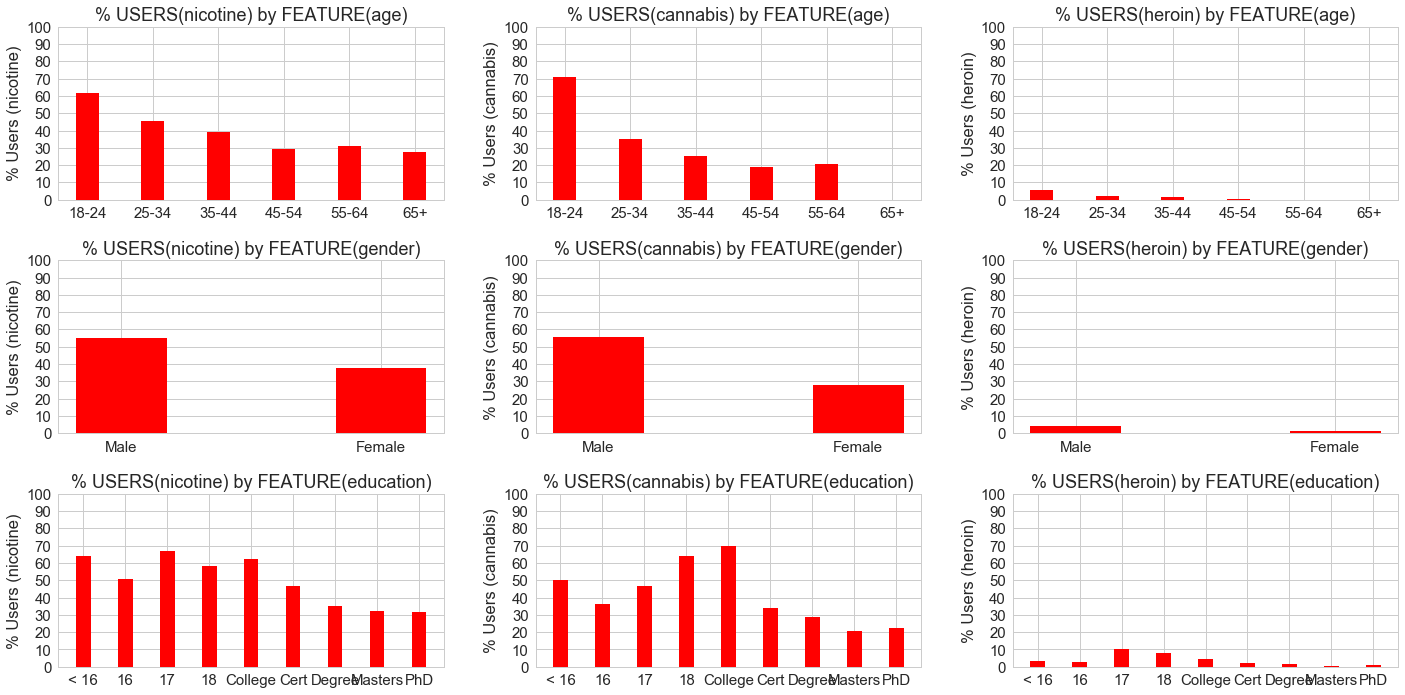

In [6]:
FEATS = ["age", "gender", "education"]
DRUGS = ["nicotine", "cannabis", "heroin"]

FEATURE_INDEXES = {k:v for v, k in enumerate(constants.FEATURE_COLUMNS)}
def list_diff(first, second):
    return [item for item in first if item not in second]
DRUG_INDEXES = {k:v for v, k in enumerate(list_diff(constants.CSV_COLUMNS, constants.FEATURE_COLUMNS))}
def get_feat_index(feature):
    return FEATURE_INDEXES[feature]
def get_drug_index(drug):
    return DRUG_INDEXES[drug]

def get_feature_vals(feature):
    feat_idx = get_feat_index(feature)
    feature_vals = set()

    for features, _ in cases:
        feature_vals.add(features[feat_idx])
    return sorted(list(feature_vals))

def usage_by_feature_vals(feature, drug, feature_vals):
    feat_idx = get_feat_index(feature)
    drug_idx = get_drug_index(drug)
    group_val_map = {float(k): 0 for k in feature_vals}
    total_cases_map = {float(k): 0 for k in feature_vals}
    
    for features, usages in cases:
        total_cases_map[features[feat_idx]] += 1
        if usages[drug_idx]:
            group_val_map[features[feat_idx]] += 1
    
    return group_val_map, total_cases_map

def plot_feats_drugs(width, height, label=True, color='r'):
    num_cols = len(DRUGS)
    num_rows = len(FEATS)

    fig, ax_arr = plt.subplots(num_rows,num_cols,figsize=(width,height))

    i = 1
    for feature in FEATS:
        feature_vals = get_feature_vals(feature)
        N = len(feature_vals)
        ind = np.arange(N)
        width = 0.35
    
        for drug in DRUGS:
            use, total = usage_by_feature_vals(feature, drug, feature_vals)
            
            index = (FEATS.index(feature), DRUGS.index(drug)) if len(FEATS) > 1 else DRUGS.index(drug)
            ax = ax_arr[index]
            rects = ax.bar(ind+width, [(use[val]/total[val])*100 for val in feature_vals], width, color=color)
            ax.set_ylabel("% Users (" + drug + ")")
            ax.set_title("% USERS(" + drug + ") by FEATURE(" + feature + ")")
            ax.set_xticks(ind+width)
            ax.set_xticklabels((val_to_label[feature][val] for val in feature_vals) if label else [])
            ax.set_yticks(range(0,110,10))
            ax.set_yticklabels(i for i in range(0,110,10))
            i += 1
    plt.tight_layout()
    plt.show()
    
plot_feats_drugs(20,10)

The code above uses the lists `FEATS` and `DRUGS` initialized at the beginning to plot graphs of the percentage of individuals with each feature who use each drug.  With the sample I have selected, we can observe a few interesting properties.

Nicotine is the only legal (in surveyed countries) selection in these three, yet we can see that a very similar percentage of men and women smoke nicotine as smoke cannabis.

Lower levels of education seem to positively correlate with usage of nicotine more than with usage of cannabis, which peaks with those who have at least entered college and then drops quickly after receiving any sort of certificate or diploma.

Heroin is very sparsely represented in the sample (as one might expect), yet follows similar trends to the other two drugs by age, gender and education.  It is curious that it is represented more in the groups of people who left school at 17 or 18 years old and not earlier, but this could be due to very low sample size for those groups (127 individuals reported <16 or 16, 130 individuals reported 17, 18).

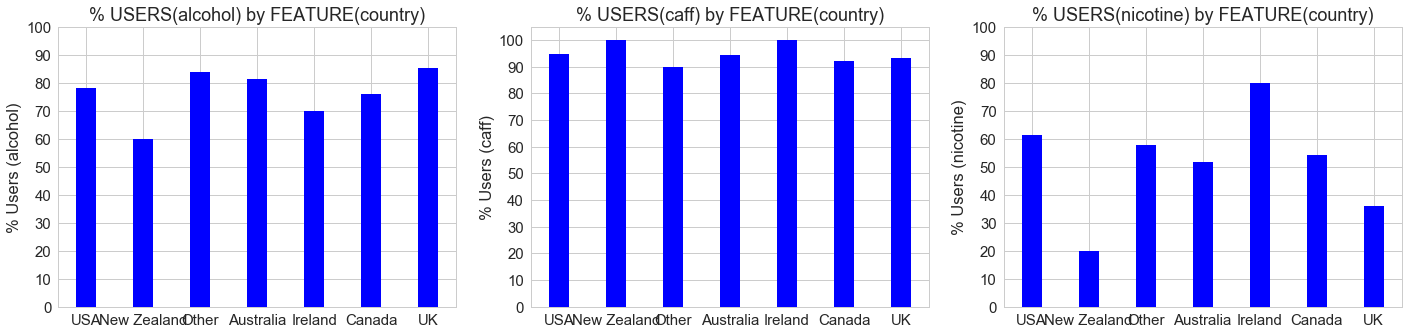

In [7]:
FEATS = ["country"]
DRUGS = ["alcohol", "caff", "nicotine"]

plot_feats_drugs(20,5,color='b')

Looking at three highly used substances (total users in dataset: 1551, 1764, 875 respectively), we can see that there is generally low variation by country except in nicotine.  Although New Zealand is a clear outlier (only 5 individuals in the sample), the UK and USA comparison is striking.  This suggests that country could be noise for alcohol and caffeine, but a useful signal for nicotine (although this is of course a huge simplifcation and some combination of country and other columns could create signal).

Now I'll look at personality test scores.

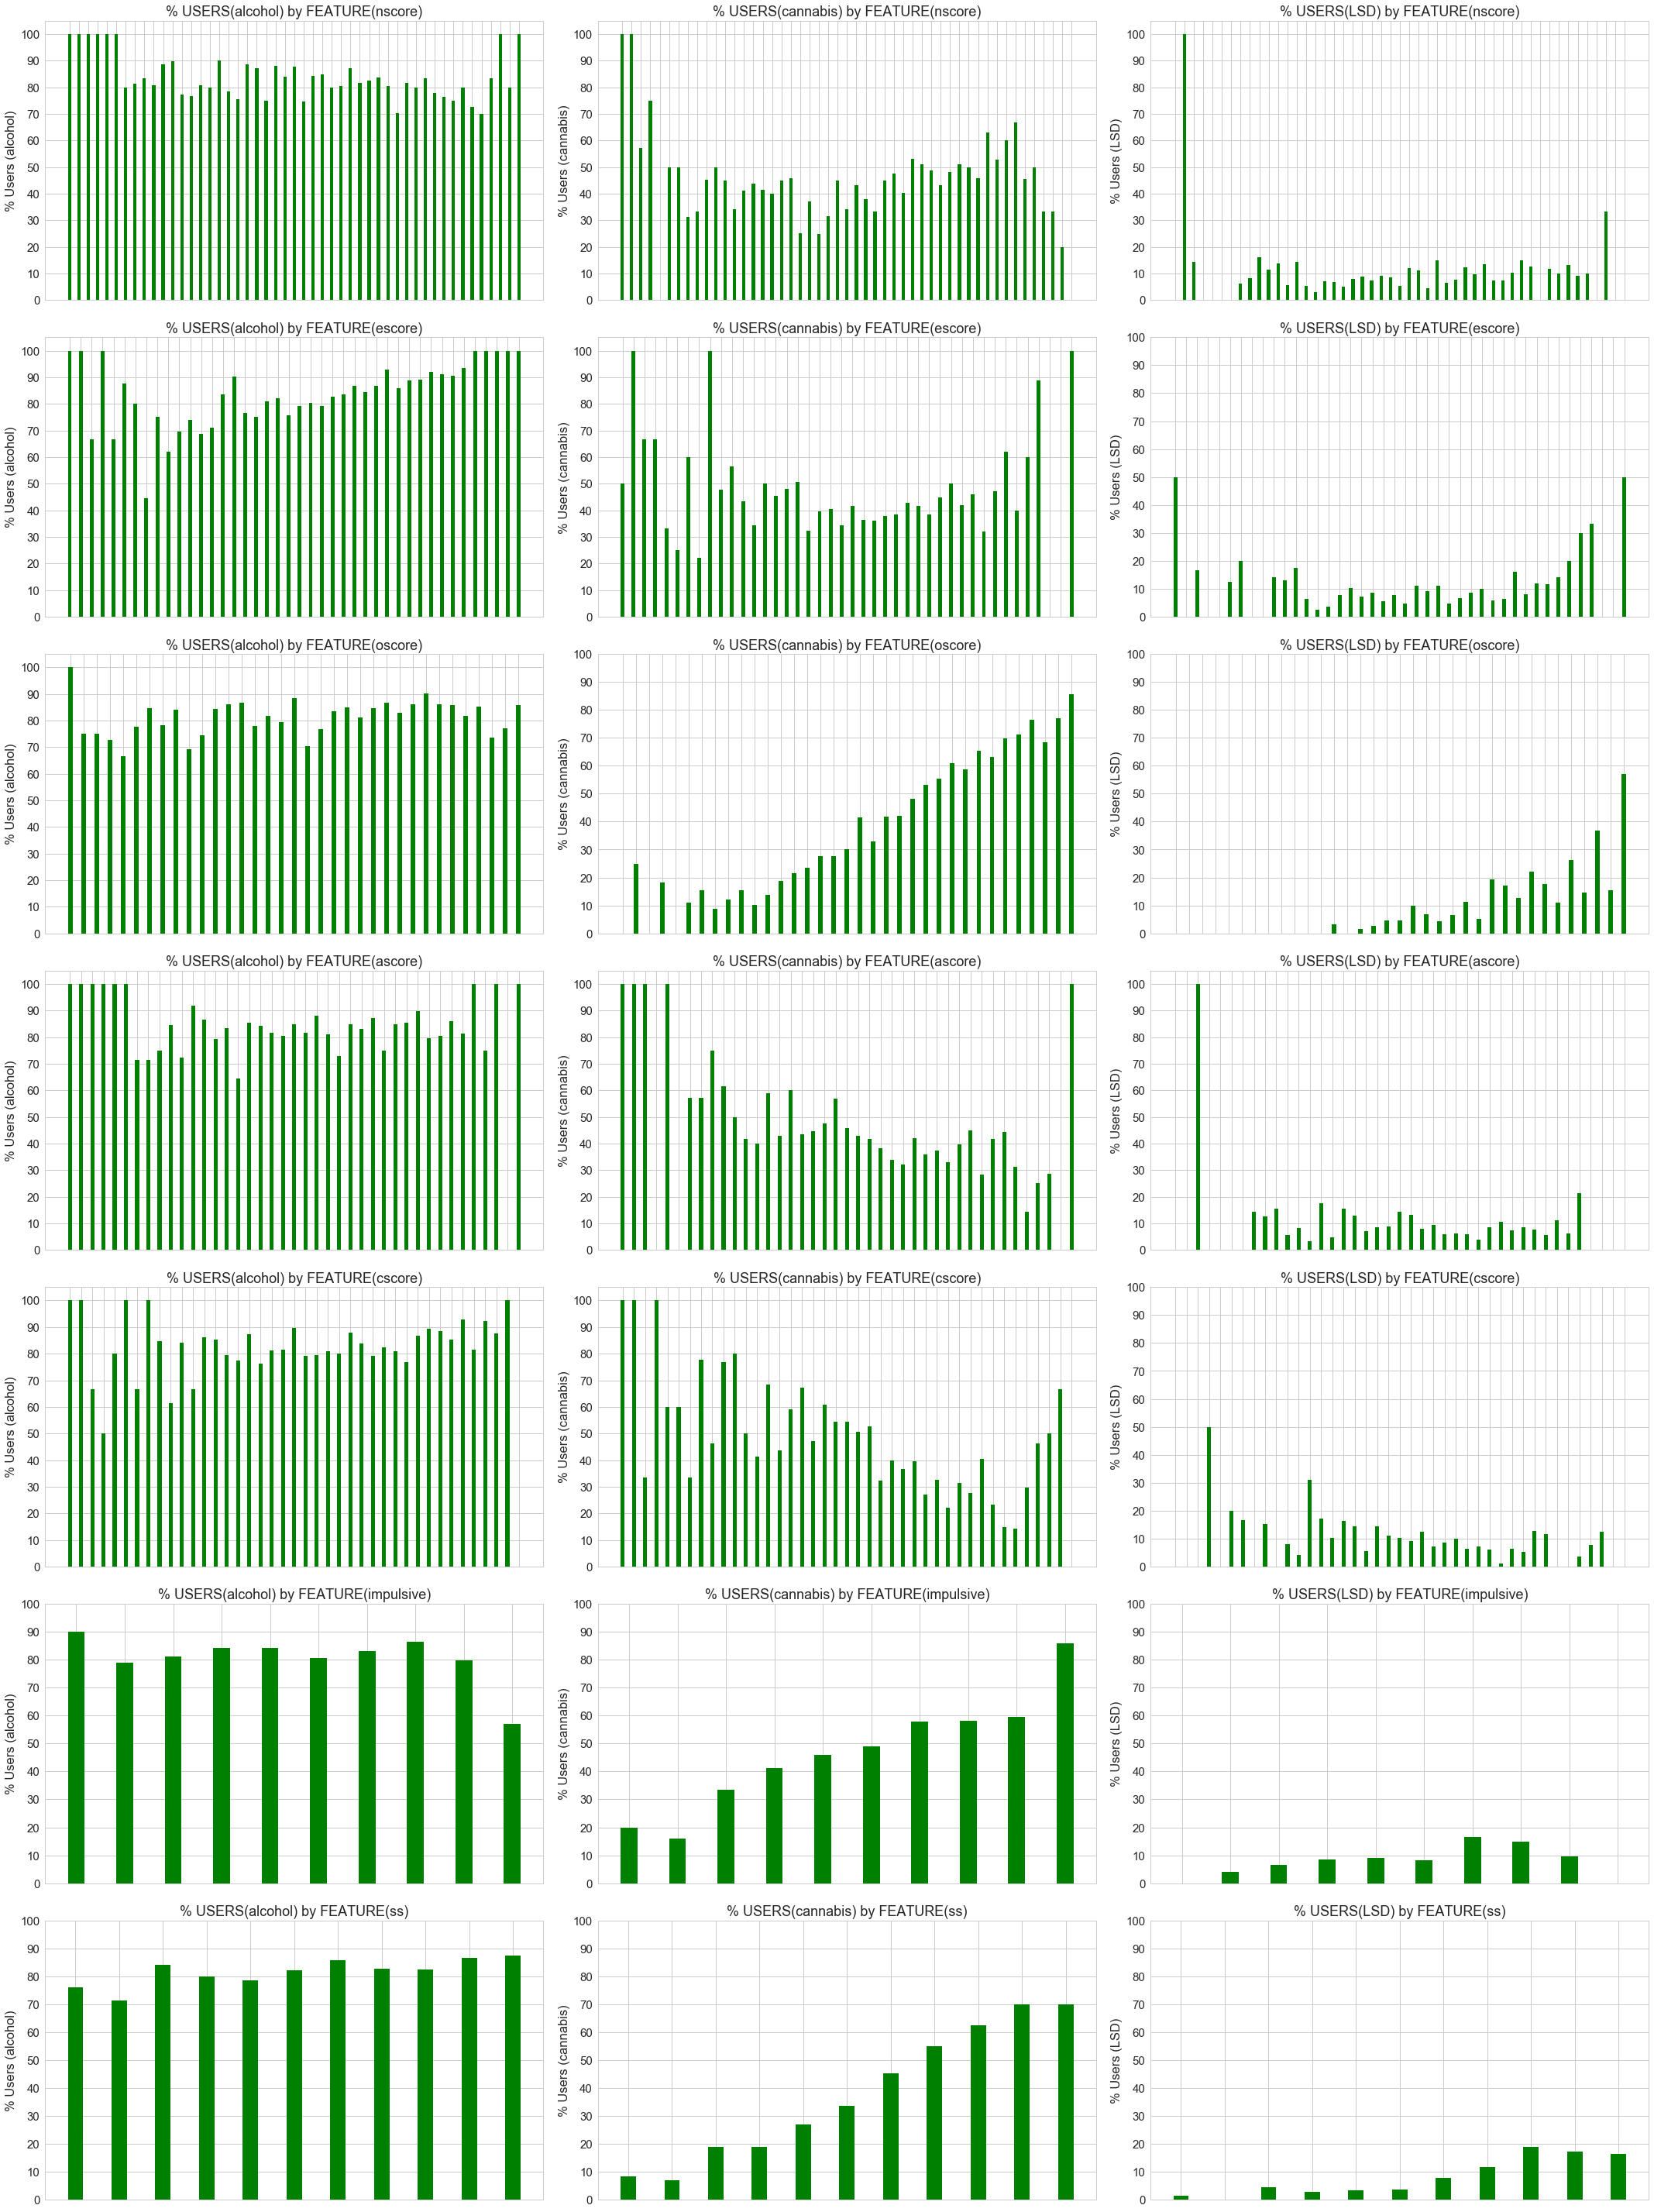

In [8]:
FEATS = ["nscore", "escore", "oscore", "ascore", "cscore", "impulsive", "ss"]
DRUGS = ["alcohol", "cannabis", "LSD"]

plot_feats_drugs(30,40,label=False,color='g')

So from this we can tell a few things:

#### 1. Alcohol does not care about your personality
Basically every one of the alcohol charts looks the same: ~80% of people drink alcohol.

#### 2. Cannabis is positively associated with oscore, impulsiveness, and sensation-seeking
The signal from these is actually pretty strong, there is very little deviation from a positive correlation.
Oscore is a measure of openness to new experience, and the others are self-explanatory.
    
#### 3. Cannabis is negatively associated with ascore and cscore
The signal from these is not quite so clear, with a noticeable rise at the positive extreme after declining 
otherwise.  Ascore is a measure of agreeableness, and cscore is a measure of conscientiousness.
    
#### 4. LSD is positively associated with escore, oscore, impulsiveness, and sensation-seeking
The signal from these is strong from oscore and sensation-seeking but somewhat weak from the others.
Escore is a measure of extraversion, and this is the trait that separates LSD's positive indicators
from those of cannabis.  People who are more extraverted are more likely to have tried LSD but not more
likely to have tried cannabis.
    
#### 5. LSD is negatively associated with cscore
There is a weak negative correlation between cscore (conscientiousness) and usage of LSD.

# Personality Profiles by Drug

In [9]:
# NOTE: These scores are slightly inaccuracte because certain scores were not found in the dataset
# for example ascores begin 12, 16, 18, 23... while this will return 12, 13, 14, 15...
# Due to this issue, treat the graphs as approximate.
def map_personality_vals(feat, offset):
    return { y: x+offset for x, y in enumerate(get_feature_vals(feat)) }

nscore_vals = map_personality_vals("nscore", 12)
escore_vals = map_personality_vals("escore", 16)
oscore_vals = map_personality_vals("oscore", 24)
ascore_vals = map_personality_vals("ascore", 12)
cscore_vals = map_personality_vals("cscore", 17)

In [22]:
def plot_personality_prof(drug, axis, with_average=False):
    drug_index = get_drug_index(drug)
    horiz_axis = [x for x in range(5)]
    personality_feats = ["oscore", "cscore", "escore", "ascore", "nscore"]
    feat_values = [oscore_vals, cscore_vals, escore_vals, ascore_vals, nscore_vals]
    feat_indexes = [get_feat_index(x) for x in personality_feats]
    feat_totals = [0 for x in personality_feats]
    running_totals = [0 for x in personality_feats]
    num_users = 0

    for features, usages in cases:
        user = usages[drug_index]
        if user:
            num_users += 1
        for i in range(len(feat_indexes)):
            idx = feat_indexes[i]
            # This is only for the given drug
            if user:
                feat_totals[i] += feat_values[i][features[idx]]
            # This is for the overall average
            running_totals[i] += feat_values[i][features[idx]]
                
    if num_users > 0:
        feat_averages = [float(x/num_users) for x in feat_totals]
        overall_averages = [float(x/len(cases)) for x in running_totals]
    
        axis.plot(horiz_axis, feat_averages, label=drug)
        axis.plot(horiz_axis, overall_averages, color='g', label="average")
        axis.legend(loc='upper right')
        axis.set_ylabel("Average Score")
        axis.set_title("Personality Profile (" + drug + ")")
        axis.set_xticks(horiz_axis)
        axis.set_xticklabels(personality_feats)
        axis.set_yticks(range(0,80,5))
        axis.set_yticklabels(i for i in range(0,80,5))
    else:
        print("No users of " + drug + " found.")

In [23]:
def plot_personality_profiles(drugs, cols=3, width=8, height=8):
    if len(drugs) < (cols+1):
        NUM_ROWS = 1
        NUM_COLS = len(drugs)
    else:
        NUM_ROWS = math.ceil(len(drugs)/cols)
        NUM_COLS = cols

    fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(width*NUM_COLS, height*NUM_ROWS))
    axes = axes.flatten()
    for i in range(len(drugs)):
        plot_personality_prof(drugs[i], axes[i])
        
    plt.tight_layout()
    plt.show()

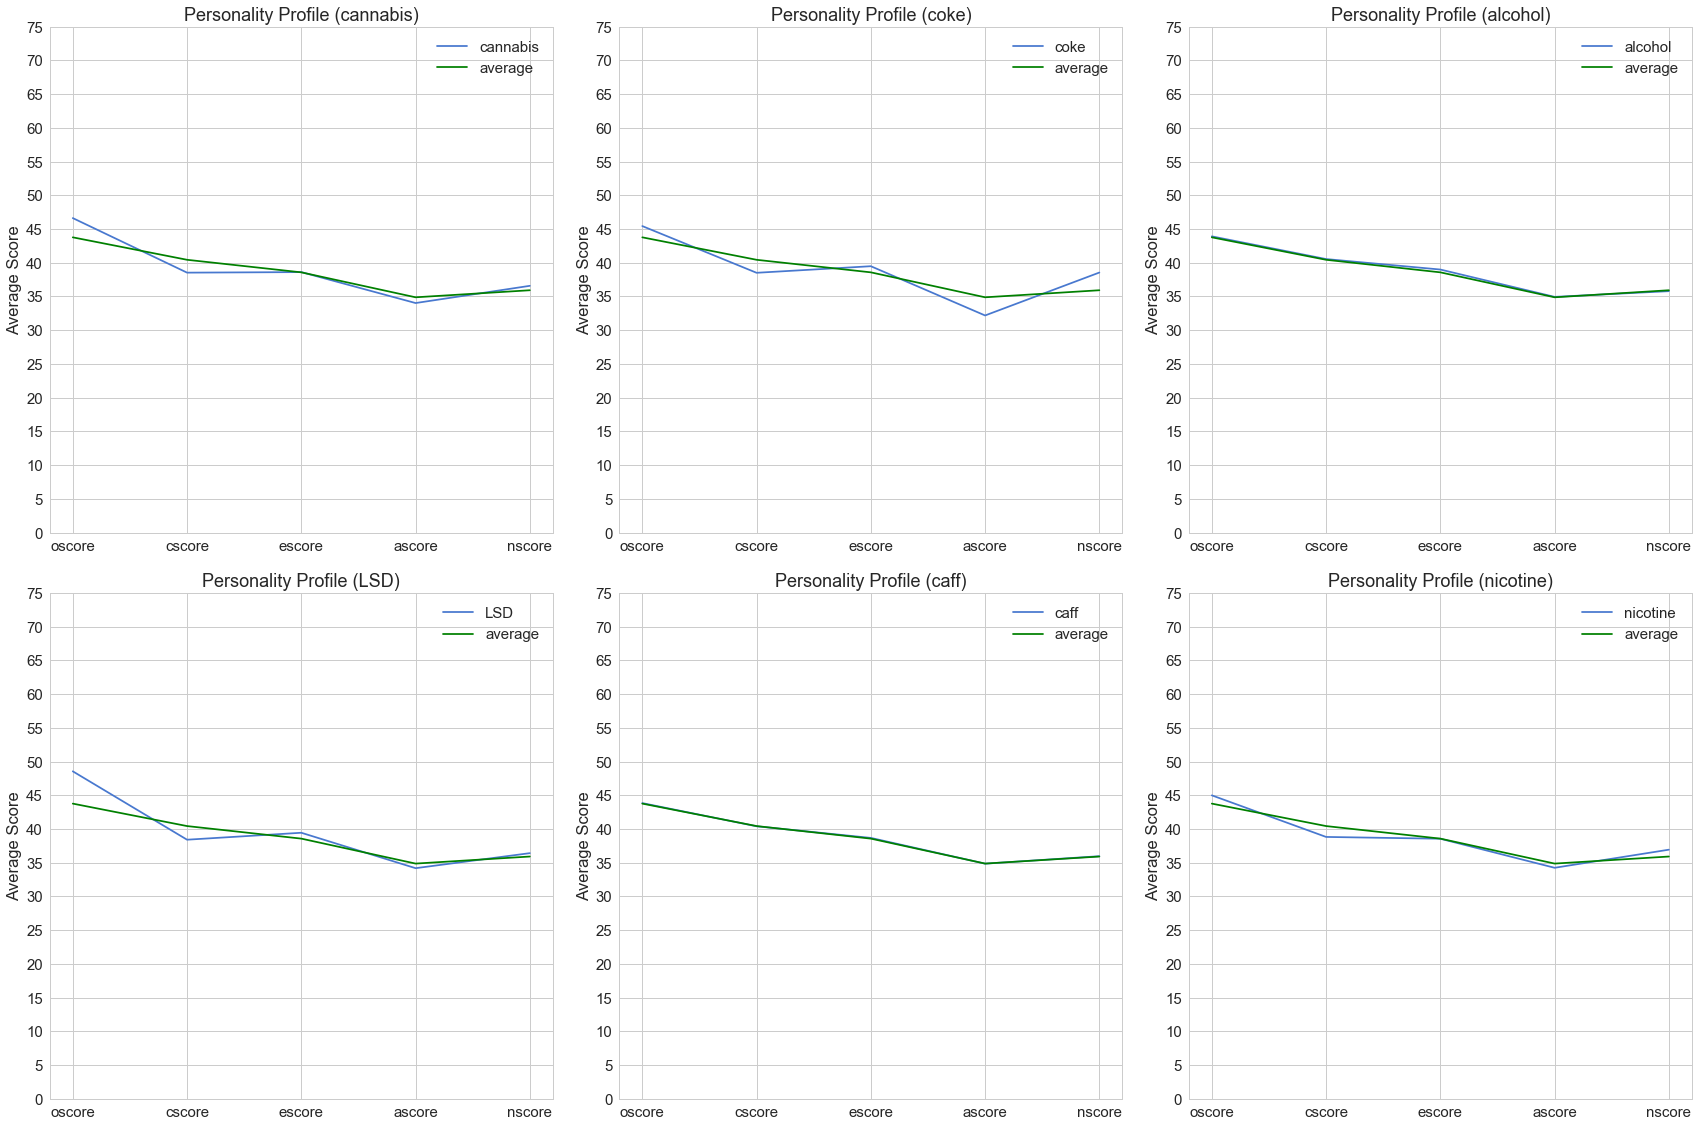

In [24]:
plot_personality_profiles(["cannabis", "coke", "alcohol", "LSD", "caff", "nicotine"])

These graphs use the average value of each of the Big Five personality traits for both the total population and the population which uses the given drug.  Both plotted lines are put onto the same graph to allow for easy comparison.